In [104]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/review/reviews_v1_hiring_task.csv


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from termcolor import colored
import torch 
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import FastText, vocab
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from gensim.models.phrases import Phrases, Phraser
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
from string import punctuation
import re, random, pathlib
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

from transformers import RobertaModel, RobertaTokenizer, get_linear_schedule_with_warmup, AutoTokenizer, AutoModel

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

path_files = pathlib.Path('./')

In [107]:
data    = pd.read_csv('/kaggle/input/review/reviews_v1_hiring_task.csv', sep=',', encoding='latin-1').sample(500)
data.head()

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
505,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-02-24T00:00:00.000Z,2017-05-21T05:55:55Z,"2017-04-30T00:42:00.000Z,2017-06-07T09:03:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,Great little tablet after you add google play ...,Great Value after additions,NaN,NaN,oldandretired
1211,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-05-17T00:00:00.000Z,2017-07-03T23:08:39Z,2017-06-07T09:03:00.000Z,...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,"Mainly used for reading kindle books, but tabl...",Perfect tablet!,NaN,NaN,Tobey
336,AV1YnRtnglJLPUi8IJmV,Amazon Kindle Paperwhite - eBook reader - 4 GB...,B00OQVZDJM,Amazon,"Walmart for Business,Office Electronics,Tablet...","amazon/b00oqvzdjm,848719056099,amazonkindlepap...",Amazon,2015-12-28T00:00:00.000Z,2017-09-05T22:09:30Z,"2017-08-31T22:34:01.009Z,2017-08-02T19:49:40.2...",...,True,NaN,1.0,2.0,http://reviews.bestbuy.com/3545/9439005/review...,Not a big reader but gave it to someone that i...,Good for reading,NaN,NaN,Enduser
458,AV1YnRtnglJLPUi8IJmV,Amazon Kindle Paperwhite - eBook reader - 4 GB...,B00OQVZDJM,Amazon,"Walmart for Business,Office Electronics,Tablet...","amazon/b00oqvzdjm,848719056099,amazonkindlepap...",Amazon,2015-11-23T00:00:00.000Z,2017-09-05T22:09:30Z,"2017-08-31T22:34:03.138Z,2017-08-02T19:49:46.8...",...,True,NaN,1.0,5.0,http://reviews.bestbuy.com/3545/9439005/review...,Text is very crisp and easy to read. Would rec...,Great e reader,NaN,NaN,Jesus
583,AV1YnRtnglJLPUi8IJmV,Amazon Kindle Paperwhite - eBook reader - 4 GB...,B00OQVZDJM,Amazon,"Walmart for Business,Office Electronics,Tablet...","amazon/b00oqvzdjm,848719056099,amazonkindlepap...",Amazon,2017-07-08T00:00:00.000Z,2017-09-05T22:09:30Z,"2017-08-31T22:33:03.861Z,2017-08-02T19:54:05.2...",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/9439005/review...,There is no difference in reading from a book ...,Started reading more after buying this,NaN,NaN,Sravan


In [109]:
data.shape


(500, 21)

Feature Engineering

In [111]:
Notkeep = [d for d in data.columns if d not in ['reviews.text','reviews.text','reviews.rating','manufacturer','reviews.date','name','id','brand','categories']]
data = data.drop(columns=Notkeep)
data

,id,name,brand,categories,manufacturer,reviews.date,reviews.rating,reviews.text
505,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,2017-02-24T00:00:00.000Z,4.0,Great little tablet after you add google play ...
1211,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,2017-05-17T00:00:00.000Z,5.0,"Mainly used for reading kindle books, but tabl..."
336,AV1YnRtnglJLPUi8IJmV,Amazon Kindle Paperwhite - eBook reader - 4 GB...,Amazon,"Walmart for Business,Office Electronics,Tablet...",Amazon,2015-12-28T00:00:00.000Z,2.0,Not a big reader but gave it to someone that i...
458,AV1YnRtnglJLPUi8IJmV,Amazon Kindle Paperwhite - eBook reader - 4 GB...,Amazon,"Walmart for Business,Office Electronics,Tablet...",Amazon,2015-11-23T00:00:00.000Z,5.0,Text is very crisp and easy to read. Would rec...
583,AV1YnRtnglJLPUi8IJmV,Amazon Kindle Paperwhite - eBook reader - 4 GB...,Amazon,"Walmart for Business,Office Electronics,Tablet...",Amazon,2017-07-08T00:00:00.000Z,5.0,There is no difference in reading from a book ...
...,...,...,...,...,...,...,...,...
770,AVqVGWLKnnc1JgDc3jF1,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",Amazon,"Tablets,Fire Tablets,Computers & Tablets,All T...",Amazon,2017-02-25T00:00:00.000Z,4.0,The parental control could be a lot better. It...
85,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,2016-12-07T00:00:00.000Z,3.0,"Ok tablet from amazon, added Google play to de..."
1121,AVphPmHuilAPnD_x3E5h,"Kindle Voyage E-reader, 6 High-Resolution Disp...",Amazon,"Walmart for Business,Office Electronics,Tablet...",Amazon,2015-08-05T00:00:00.000Z,4.0,Great ereader. Light and easy to use. Only iss...
965,AV1YnRtnglJLPUi8IJmV,"Kindle Voyage E-reader, 6 High-Resolution Disp...",Amazon,"Walmart for Business,Office Electronics,Tablet...",Amazon,2017-01-31T00:00:00.000Z,5.0,I can't say how happy I am with this purchase....


Since we need numerical data and we have currently categorical data ,droppig duplicated and missing values

In [113]:
types_str = data.select_dtypes(include='object').columns
types_int = data.select_dtypes(include=[int,float]).columns
data[types_str] = data[types_str].fillna('NA')
data[types_int] = SimpleImputer(strategy='mean').fit_transform(data[types_int])
# Drop Duplicates
duplicate = data[['reviews.rating', 'reviews.text','id']].duplicated()
data      = data.loc[duplicate==False]
data = data.reset_index()
print('Drop Duplicated:',duplicate.sum())

# Final frame
cols = ['reviews.rating', 'reviews.text','id']
df = data[cols]
df.fillna(' ',inplace=True)
df['reviews.text'].astype(str)
df['reviews.rating'].astype(str)
df['id'].astype(str)

Drop Duplicated: 0


/tmp/ipykernel_34/3654791195.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(' ',inplace=True)


0      AVqkIhwDv8e3D1O-lebb
1      AVqkIhwDv8e3D1O-lebb
2      AV1YnRtnglJLPUi8IJmV
3      AV1YnRtnglJLPUi8IJmV
4      AV1YnRtnglJLPUi8IJmV
               ...         
495    AVqVGWLKnnc1JgDc3jF1
496    AVqkIhwDv8e3D1O-lebb
497    AVphPmHuilAPnD_x3E5h
498    AV1YnRtnglJLPUi8IJmV
499    AV1YnRtnglJLPUi8IJmV
Name: id, Length: 500, dtype: object

We are doing feature engineering herereebank tokenizer uses regular expressions to tokenize text a

In [114]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
stemmer = WordNetLemmatizer()
tok = TreebankWordTokenizer()# The Treebank tokenizer uses regular expressions to tokenize text 

nltk.download('stopwords')
en_stop       = set(nltk.corpus.stopwords.words('english'))
to_be_removed = list(en_stop) + list(punctuation) 

# Preprocess text for transformers
def preprocess_transformers(document, full_process=True):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)
        # Converting to Lowercase
        document = document.lower()
        if full_process:
            # Lemmatization
            tokens = document.split()
            tokens = [stemmer.lemmatize(word) for word in tokens]
            tokens = [word for word in tokens if word not in en_stop]
            tokens = [word for word in tokens if len(word) > 3]
            document = ' '.join(tokens)
        return document

# Make phraser to detect collocations
def show_phrases(tokenized_sentences, threshold=10, shown=15):
  '''Show collocation for a corpus of tokenized sentences.'''
  phrases = Phrases(tokenized_sentences, threshold=threshold)
  i = 0
  for phrase, score in phrases.export_phrases().items():
  #for phrase, score in phrases.export_phrases(): # for other gensim version 
    if i>shown:
      break
    else:
      print("Expression : {0}, score = {1}".format(phrase, score))
    i=i+1

# Accuracy function to evaluate during training
def accuracy(preds, labels):
    pred = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(pred == labels) / len(labels)

def tokenize_pad_numericalize(entry, vocab_stoi, tok, pad=True, max_length=100):
    if pad :
        text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi[''] for token in tok.tokenize(entry)]
        padded_text = None
        l = len(text)
        if l < max_length:   padded_text = text + [ vocab_stoi[''] for i in range(len(text), max_length) ] 
        elif l > max_length: padded_text = text[:max_length]
        else:                        padded_text = text
        return padded_text
    else : 
        text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi[''] for token in tok.tokenize(entry)]
        return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'punctuation' is not defined

In [195]:
df = data[['reviews.text','reviews.rating','reviews.date','name','manufacturer']]
df #getting the clean data

,reviews.text,reviews.rating,reviews.date,name,manufacturer
0,Great little tablet after you add google play ...,4.0,2017-02-24T00:00:00.000Z,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon
1,"Mainly used for reading kindle books, but tabl...",5.0,2017-05-17T00:00:00.000Z,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon
2,Not a big reader but gave it to someone that i...,2.0,2015-12-28T00:00:00.000Z,Amazon Kindle Paperwhite - eBook reader - 4 GB...,Amazon
3,Text is very crisp and easy to read. Would rec...,5.0,2015-11-23T00:00:00.000Z,Amazon Kindle Paperwhite - eBook reader - 4 GB...,Amazon
4,There is no difference in reading from a book ...,5.0,2017-07-08T00:00:00.000Z,Amazon Kindle Paperwhite - eBook reader - 4 GB...,Amazon
...,...,...,...,...,...
495,The parental control could be a lot better. It...,4.0,2017-02-25T00:00:00.000Z,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",Amazon
496,"Ok tablet from amazon, added Google play to de...",3.0,2016-12-07T00:00:00.000Z,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon
497,Great ereader. Light and easy to use. Only iss...,4.0,2015-08-05T00:00:00.000Z,"Kindle Voyage E-reader, 6 High-Resolution Disp...",Amazon
498,I can't say how happy I am with this purchase....,5.0,2017-01-31T00:00:00.000Z,"Kindle Voyage E-reader, 6 High-Resolution Disp...",Amazon



Preprocessing for Transformers

Since the models need inputs of equal length, we need to pad sequences tokenized sentences. We provide the maximum length based on the larges size of headline. On top of the word ids, the model requires an attention mask to indicate where the input sentences are padded or not.


In [197]:


df.head()



,reviews.text,reviews.rating,reviews.date,name,manufacturer
0,Great little tablet after you add google play ...,4.0,2017-02-24T00:00:00.000Z,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon
1,"Mainly used for reading kindle books, but tabl...",5.0,2017-05-17T00:00:00.000Z,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon
2,Not a big reader but gave it to someone that i...,2.0,2015-12-28T00:00:00.000Z,Amazon Kindle Paperwhite - eBook reader - 4 GB...,Amazon
3,Text is very crisp and easy to read. Would rec...,5.0,2015-11-23T00:00:00.000Z,Amazon Kindle Paperwhite - eBook reader - 4 GB...,Amazon
4,There is no difference in reading from a book ...,5.0,2017-07-08T00:00:00.000Z,Amazon Kindle Paperwhite - eBook reader - 4 GB...,Amazon


In [199]:


#split train test
from sklearn.model_selection import train_test_split


X=df['reviews.text']
y=df['reviews.rating']




Optimization Settings

We use Adam gradient descent that combines decaying averages of past and past squared gradients and generally offers good performances. We add a linear scheduler for the learning rate to smooth the optimization process.


X = train['Cleared Review'].apply(lambda text: ' '.join(text))
Y = train['Score']

In [201]:
models_metrics = pd.DataFrame({'Name':['LinReg', 'DesTree', 'RanFor'],
                               'Accuracy':[0, 0, 0],
                               'RMSE':[0, 0, 0],
                               'R^2':[0, 0, 0]})

models_metrics.set_index('Name', inplace=True)

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import re
import string
import seaborn as sns
import nltk 
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from collections import Counter

In [205]:
def get_report(test_data, predicted_data, model_name=''):
    metrics = [mean_squared_error(test_data, predicted_data, squared=False),
              r2_score(test_data, predicted_data),
              accuracy_score(test_data, predicted_data)]
    if model_name:
        models_metrics.at[model_name, 'RMSE'] = metrics[0]
        models_metrics.at[model_name, 'Accuracy'] = metrics[2]
        models_metrics.at[model_name, 'R^2'] = metrics[1]
    print(f'The RMSE on data is: {metrics[0]}')
    print(f'The R2 on data is: {metrics[1]}')
    print(f'Accuracy is: {metrics[2]}')

In [231]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Assuming X and y are your original data
# X, y = ... 

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply one-hot encoding only to the feature variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align columns of X_test to match X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Ensure y_train and y_test are 1-dimensional
y_train = y_train if y_train.ndim == 1 else y_train.iloc[:, 0]
y_test = y_test if y_test.ndim == 1 else y_test.iloc[:, 0]

# Initialize and fit the logistic regression model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Make predictions on the test data
log_test_pred = log_model.predict(X_test)

log_train_pred = log_model.predict(X_train)

In [234]:
print("Metrics for test data:")
get_report(y_test, log_test_pred, 'LinReg')
print("\nMetrics for train data:")
get_report(y_train, log_train_pred)


Metrics for test data:
The RMSE on data is: 1.5620499351813308
The R2 on data is: -0.6944444444444444
Accuracy is: 0.49

Metrics for train data:
The RMSE on data is: 1.4343988287781053
The R2 on data is: -0.5766963135384189
Accuracy is: 0.545


/tmp/ipykernel_34/3079172621.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5620499351813308' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  models_metrics.at[model_name, 'RMSE'] = metrics[0]
/tmp/ipykernel_34/3079172621.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.49' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  models_metrics.at[model_name, 'Accuracy'] = metrics[2]
/tmp/ipykernel_34/3079172621.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.6944444444444444' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  models_metrics.at[model_name, 'R^2'] = metrics[1]


In [236]:


def normalize_predictions(pred):
    new_pred = [i if i <= 5 else 5 for i in pred]
    new_pred = [i if i >= 1 else 1 for i in new_pred]
    new_pred = [round(i) for i in new_pred]
    return new_pred



In [245]:


tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

tree_pred_test = normalize_predictions(tree_model.predict(X_test))
tree_pred_train = normalize_predictions(tree_model.predict(X_train))



In [250]:
print("Metrics for test data:")
get_report(y_test, tree_pred_test, 'DesTree')
print("\nMetrics for train data:")
get_report(y_train, tree_pred_train)


Metrics for test data:
The RMSE on data is: 1.5620499351813308
The R2 on data is: -0.6944444444444444
Accuracy is: 0.49

Metrics for train data:
The RMSE on data is: 0.0
The R2 on data is: 1.0
Accuracy is: 1.0


In [252]:
random_forest_model = RandomForestRegressor(max_features=100)
random_forest_model.fit(X_train, y_train)

forest_test_pred = normalize_predictions(random_forest_model.predict(X_test))
forest_train_pred = normalize_predictions(random_forest_model.predict(X_train))

In [253]:

print("Metrics for test data:")
get_report(y_test, forest_test_pred, 'RanFor')
print("\nMetrics for train data:")
get_report(y_train, forest_train_pred)

Metrics for test data:
The RMSE on data is: 1.5620499351813308
The R2 on data is: -0.6944444444444444
Accuracy is: 0.49

Metrics for train data:
The RMSE on data is: 0.565685424949238
The R2 on data is: 0.7547787021471232
Accuracy is: 0.7325


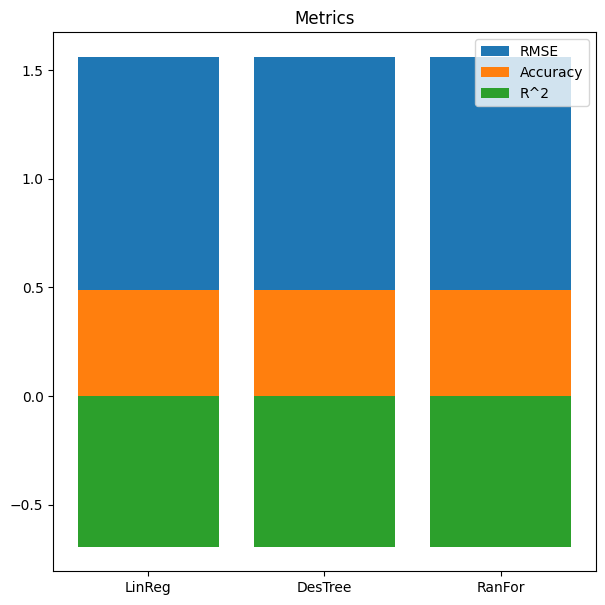

In [255]:
models_name = models_metrics.index.tolist()
plt.figure(figsize=(7,7))
plt.bar(models_name, models_metrics['RMSE'], label='RMSE')
plt.bar(models_name, models_metrics['Accuracy'], label='Accuracy')
plt.bar(models_name, models_metrics['R^2'], label='R^2')
plt.title('Metrics')
plt.legend()
plt.show()

In [257]:
tfidf = TfidfVectorizer(min_df=0.001)
tfidf_data = tfidf.fit_transform(X)

tfidf_data = pd.DataFrame(tfidf_data.toarray(), columns=tfidf.get_feature_names_out())
tfidf_data.head()


,01,10,100,1000,11,12,13th,15,16,16gb,...,you,young,younger,youngest,your,yourself,youtube,yr,yrs,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.186374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [261]:
X_train_idf = tfidf_data.loc[X_train.index,:]
X_test_idf = tfidf_data.loc[X_test.index,:]

In [263]:


X_train_idf.shape, X_test_idf.shape



((400, 1955), (100, 1955))

In [267]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_idf, y_train)

idf_log_test = log_model.predict(X_test_idf)
idf_log_train = log_model.predict(X_train_idf)

In [269]:
print("Metrics for test data")
get_report(y_test, idf_log_test, 'LinReg')
print("\nMetrics for train data")
get_report(y_train, idf_log_train)

Metrics for test data
The RMSE on data is: 1.5099668870541498
The R2 on data is: -0.5833333333333333
Accuracy is: 0.5

Metrics for train data
The RMSE on data is: 1.2308533625091171
The R2 on data is: -0.16096958202221368
Accuracy is: 0.6975


In [273]:
tree_model = DecisionTreeRegressor(max_depth=10)
tree_model.fit(X_train_idf, y_train)

idf_tree_test = normalize_predictions(tree_model.predict(X_test_idf))
idf_tree_train = normalize_predictions(tree_model.predict(X_train_idf))

In [272]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3,5,10,20,50,70],
}

clf = DecisionTreeRegressor(random_state=42)
grid_cv = GridSearchCV(clf, param_grid, n_jobs=-1).fit(X_train_idf, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)

Param for GS {'max_depth': 3}
CV score for GS -0.024281291347035893


In [283]:


r2 = list()
x = [10, 20, 30, 50, 70, 100]

for depth in x:
    tree_model = DecisionTreeRegressor(max_depth=depth)
    tree_model.fit(X_train_idf, y_train)
    idf_tree_test = normalize_predictions(tree_model.predict(X_test_idf))
    r2.append(r2_score(y_test, idf_tree_test))



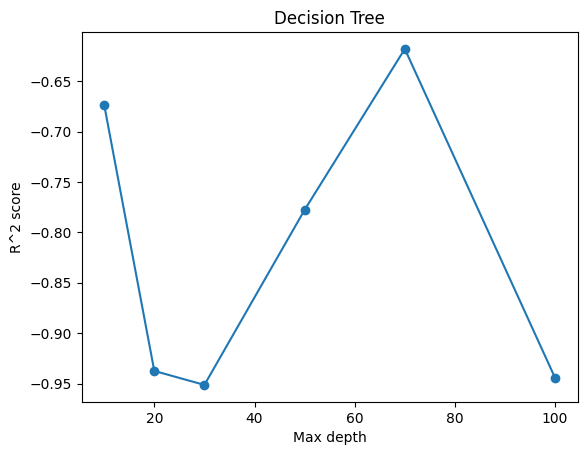

In [285]:
plt.scatter(x, r2)
plt.plot(x, r2, '-')
plt.xlabel('Max depth')
plt.ylabel('R^2 score')
plt.title('Decision Tree')
plt.show()

In [289]:
tree_model = DecisionTreeRegressor(max_depth=20)
tree_model.fit(X_train_idf, y_train)

idf_tree_test = normalize_predictions(tree_model.predict(X_test_idf))
idf_tree_train = normalize_predictions(tree_model.predict(X_train_idf))


In [291]:
print("Metrics for test data")
get_report(y_test, idf_tree_test, 'DesTree')
print("\nMetrics for train data")
get_report(y_train, idf_tree_train)

Metrics for test data
The RMSE on data is: 1.61245154965971
The R2 on data is: -0.8055555555555556
Accuracy is: 0.48

Metrics for train data
The RMSE on data is: 0.4716990566028302
The R2 on data is: 0.8294945663366716
Accuracy is: 0.8375


In [293]:
mse_test = list()
mse_train = list()
x = [20, 50, 100, 200, 300, 500]

for num in x:
    random_forest_model = RandomForestRegressor(max_features=num)
    random_forest_model.fit(X_train_idf, y_train)
    idf_forest_test = normalize_predictions(random_forest_model.predict(X_test_idf))
    idf_forest_train = normalize_predictions(random_forest_model.predict(X_train_idf))
    mse_test.append(mean_squared_error(y_test, idf_forest_test))
    mse_train.append(mean_squared_error(y_train, idf_forest_train))


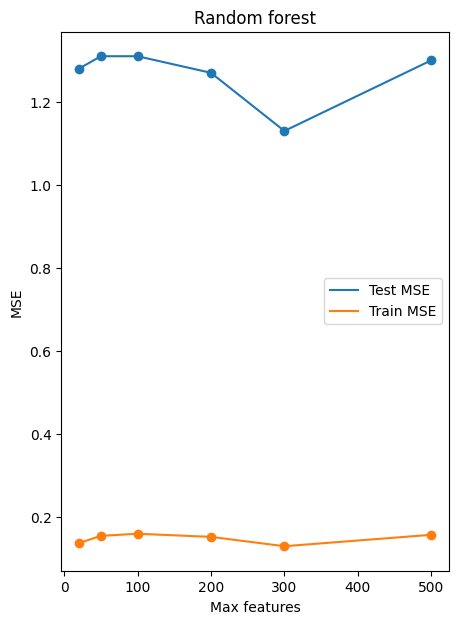

In [295]:
plt.figure(figsize=(5,7))
plt.scatter(x, mse_test)
plt.scatter(x, mse_train)
plt.plot(x, mse_test, '-', label='Test MSE')
plt.plot(x, mse_train, '-', label='Train MSE')
plt.xlabel('Max features')
plt.ylabel('MSE')
plt.title('Random forest')
plt.legend()
plt.show()


In [300]:
random_forest_model = RandomForestRegressor(max_features=200)
random_forest_model.fit(X_train_idf, y_train)
idf_forest_test = normalize_predictions(random_forest_model.predict(X_test_idf))
idf_forest_train = normalize_predictions(random_forest_model.predict(X_train_idf))

print("Metrics for test data")
get_report(y_test, idf_forest_test, 'RanFor')
print("\nMetrics for test data")
get_report(y_train, idf_forest_train)

Metrics for test data
The RMSE on data is: 1.1090536506409416
The R2 on data is: 0.14583333333333337
Accuracy is: 0.42

Metrics for test data
The RMSE on data is: 0.3640054944640259
The R2 on data is: 0.8984630563577932
Accuracy is: 0.8675


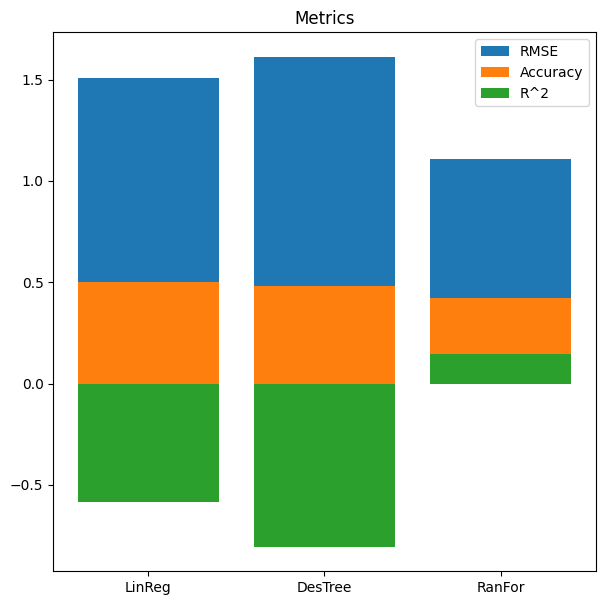

In [302]:


models_name = models_metrics.index.tolist()
plt.figure(figsize=(7,7))
plt.bar(models_name, models_metrics['RMSE'], label='RMSE')
plt.bar(models_name, models_metrics['Accuracy'], label='Accuracy')
plt.bar(models_name, models_metrics['R^2'], label='R^2')
plt.title('Metrics')
plt.legend()
plt.show()



In [306]:
def plot_conf_matrix(cm1, cm2, model):
    labels = [1,2,3,4,5]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    plt.suptitle(model)

    # Plotting the first confusion matrix
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title('For Test data')
    axes[0].set_ylabel('Predicted')
    axes[0].set_xlabel('Actual')

    # Plotting the second confusion matrix
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title('For Train Data')
    axes[1].set_ylabel('Predicted')
    axes[1].set_xlabel('Actual')

    plt.tight_layout()
    plt.show()

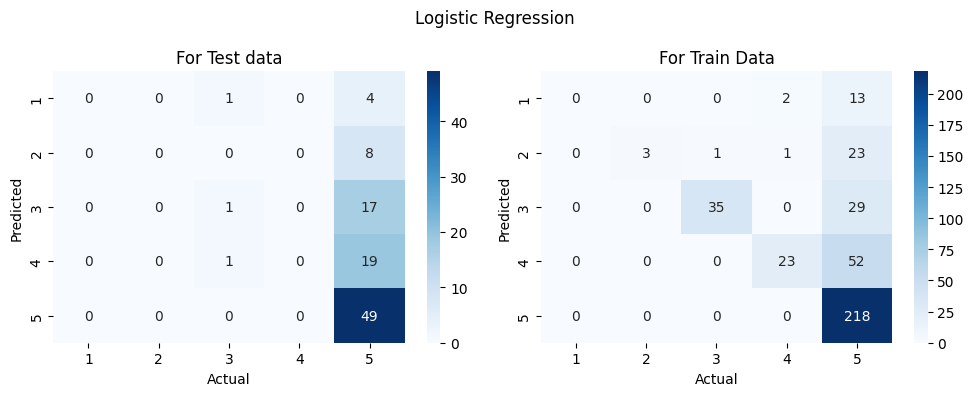

In [307]:


plot_conf_matrix(confusion_matrix(y_test, idf_log_test), confusion_matrix(y_train, idf_log_train), 'Logistic Regression')



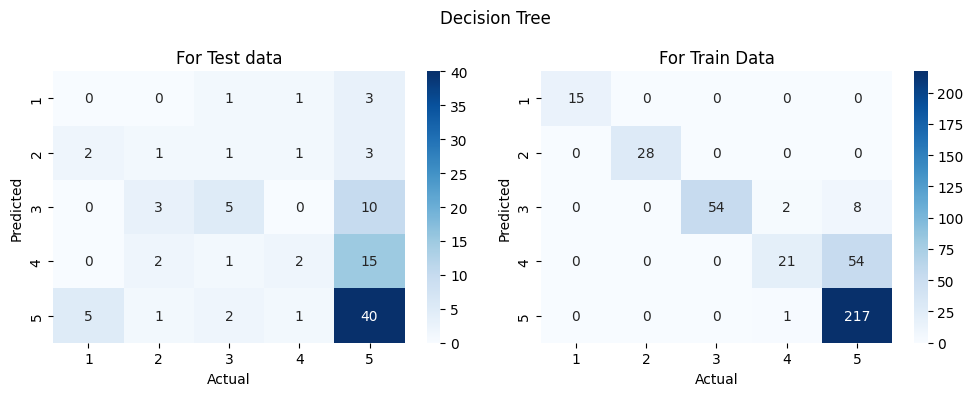

In [309]:


plot_conf_matrix(confusion_matrix(y_test, idf_tree_test), confusion_matrix(y_train, idf_tree_train), 'Decision Tree')



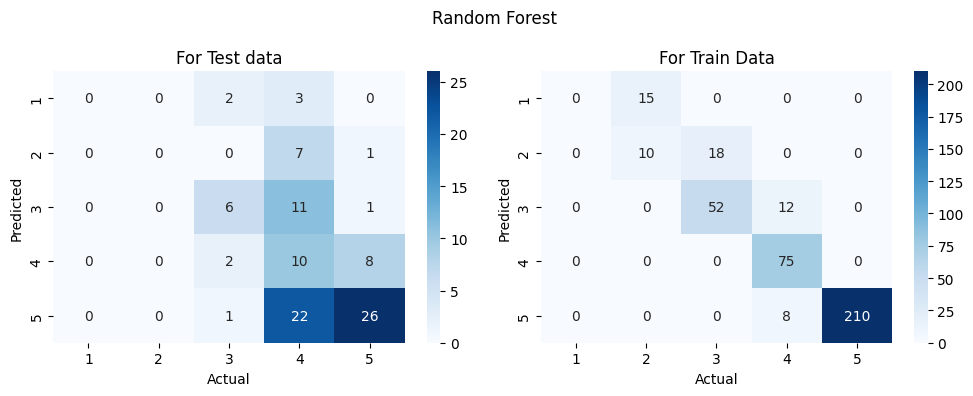

In [311]:
plot_conf_matrix(confusion_matrix(y_test, idf_forest_test), confusion_matrix(y_train, idf_forest_train), 'Random Forest')